In [2]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(sec:linear_simple)=
# Simple Linear Model

The simple linear model examines the relationship between an explanatory variable and an outcome. Tradition has us use the notation $y$ for the outcome variable and $x$ for the explanatory, and the linear model is represented as 

$$
y \approx \theta_0 + \theta_1 x. 
$$

That is, for a particular value of $x$, we explain or predict the outcome $y$ via the point on the line $\theta_0 + \theta_1 x$. As $x$ varies, all of the estimates for $y$ fall on a line. Typically, this estimate for $y$ isn't perfect, and there is some error in using the model so we use the symbol $\approx$ to mean "approximately". 

The intercept and slope for the line are often not know, and we estimate them using data, $(x_i, y_i)$ for $i=1,\ldots,n$. We do not expect these pairs of data points to fall exactly along a line, but we do expect the scatter plot of points to be reasonably described by the line and the deviations between the $y_i$ and the estimates $\theta_0 + \theta_1 x_i$  roughly symmetrically distributed about the line with no apparent patterns. 

{numref}`Figure %s <fig:SLR>` shows an idealization of this notion. On the left is a scatter plot of points with a line used to estimate $y$ from $x$. We mark two particular points a examples. The points are marked by squares and their corresponding values on the line are denoted by diamonds. The dotted line from the actual point to the line shows the error. The plot on the right is a scatter plot of all of the errors; for reference, we marked the errors corresponding to the two squares in the left plot with squares as well.

```{figure} figures/scatterplotSLR.png
---
name: fig:SLR
width: 500px
---

A scatter plot of $(x_i, y_i)$ pairs, the simple line fitted to these points, and the deviations from the estimate $\theta_0 + \theta_1 x_i$, represented as triangles on the line, to $y_i$ for two example points.
```

Linear models were first introduced in {numref}`Chapter %s <ch:pa>` where we used the relationship between high-quality air monitor operated by the Environmental Agency and neighboring inexpensive air quality monitors to calibrate the inexpensive monitors for more accurate predictions. We revisit that example to make the notion of a simple linear model more concrete.  

## Example: A Simple Linear Model for Air Quality

For this example, we look at measurements of air quality taken at a pair neighboring instruments in Alaska. These are a subset of the data we examined in the case study in {numref}`Chapter %s <ch:pa>`. Recall, air quality was measured in terms of the parts under 2.5mm in size per million in a volume of air. We have a pair of measurements for several days in May through September, 2019. 

In [106]:
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1']
full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa']

AK = full.loc[full['id'] == 'AK1', :]

from sklearn.linear_model import LinearRegression

In [107]:
AK

,date,id,region,pm25aqs,pm25pa
0,2019-05-17,AK1,Alaska,6.7,8.62
1,2019-05-18,AK1,Alaska,3.8,3.49
2,2019-05-21,AK1,Alaska,4.0,3.80
...,...,...,...,...,...
282,2019-09-25,AK1,Alaska,1.5,1.36
283,2019-09-27,AK1,Alaska,4.0,4.39
284,2019-09-30,AK1,Alaska,1.9,2.14


The following scatter plot shows a roughly linear relationship between these two sources of air quality measurements. The feature `pm25aqs` is taken from the more highly accurate device and `pm25pa` from the PurpleAir monitor.  

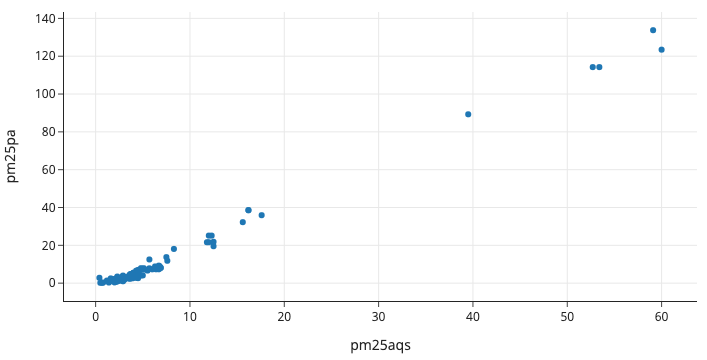

In [108]:
fig = px.scatter(AK, x="pm25aqs", y="pm25pa", 
                 width=450, height=250)

fig

Since, a few observations are quite large, we zoom into the region where measurements  are less than 20 on `pm25aqs` to see if the relationship appears linear there.

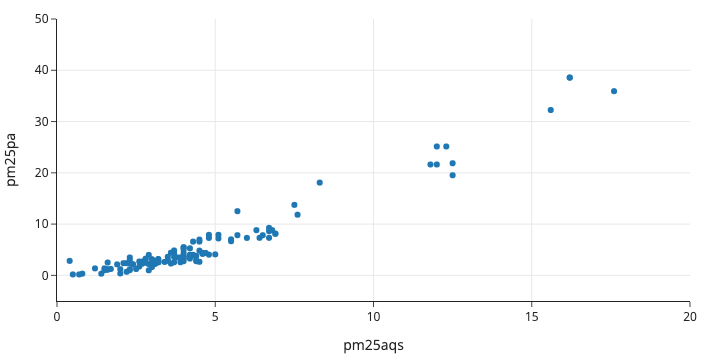

In [109]:
fig = px.scatter(AK, x="pm25aqs", y="pm25pa",
                 width=450, height=250)

fig.update_xaxes(range=[0, 20])
fig.update_yaxes(range=[-5, 50])

fig

There appears to be a slight curvature in the relationship. We hold off on discussing how to address curvilinear relationships until later in this chapter. But, as George Box famously said, "all models are wrong, but some are useful." Here is a case where we can see that despite some non-linearity in the model, we don't lose much in simplifying it to a line. 

In [110]:
import statsmodels.formula.api as sm
from statsmodels.api import add_constant

result = sm.ols(formula="pm25pa ~ pm25aqs", data=AK).fit()

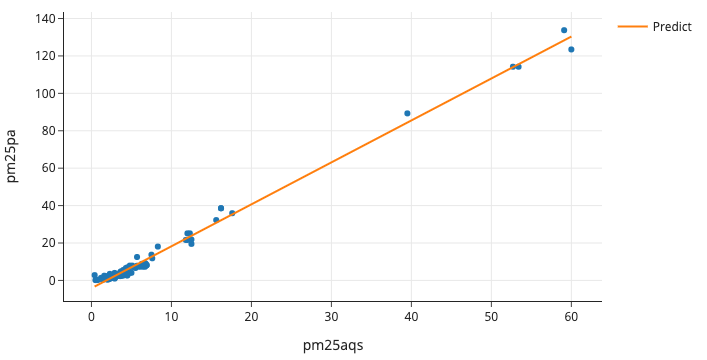

In [111]:
fig = px.scatter(AK, x="pm25aqs", y="pm25pa",
                 width=450, height=250)

pred_x = np.array([AK["pm25aqs"].min(), AK["pm25aqs"].max()])
pred_y = result.params[0] + result.params[1] * pred_x

fig.add_trace(go.Scatter(x=pred_x, 
                         y=pred_y, 
                         name='Predict', mode='lines'))
fig

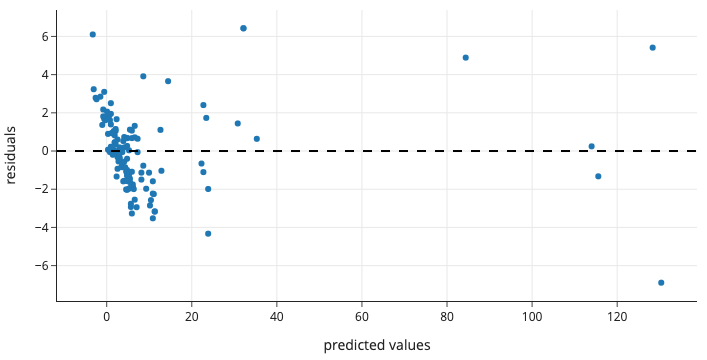

In [112]:
predicted = result.fittedvalues
residuals = result.resid

fig = px.scatter(y = residuals, x=predicted,
                 labels={
                     "y": "residuals",
                     "x": "predicted values"},
                 width=350, height=250)

#fig.update_layout(xaxis_range=[0,20])

fig.add_hline(0, line_color='black', line_width=2, line_dash='dash', opacity=1)

In [78]:
np.std(residuals)

0.9369701671540311

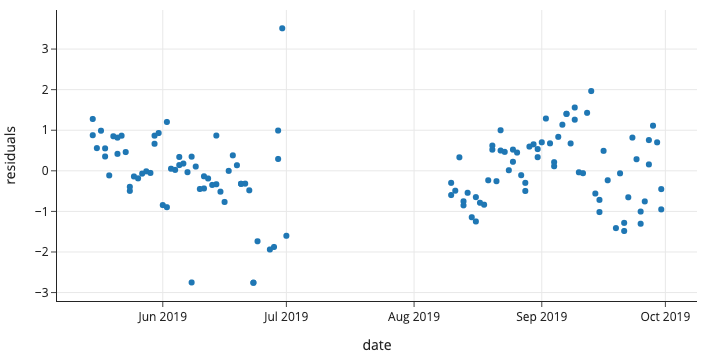

In [79]:
fig = px.scatter(x= AK["date"], y=residuals, 
                 labels={
                     "y": "residuals",
                     "x": "date"},
                 width=350, height=250)
fig

The process of finding the intercept, $\theta_0$, and slope, $\theta_1$, for the line that is closest to the data is called fitting the line or *fitting the model*. In the next section, we show how to fit the model using a loss function.   

## Fitting the Simple Linear Model

To fit a model, we use the notion of loss minimization that was first introduced in
{numref}`Chapter %s <ch:modeling>`).
The first step is to choose the loss function. Then, we find which values of
$\theta_0$ and $\theta_1$ give the smallest loss for our data.
We call $\theta_0$ and $\theta_1$ *model parameters*, and we often represent them as a column vector ${\vec{\theta}} = [\theta_0, \theta_1]$.

To fit a linear model, we typically choose squared loss, where for a given data point $(x,y)$ and model parameters $\vec{\theta}$, the squared loss is:

$$
{\cal l}(\vec{\theta}, x, y) = [y - (\theta_0 + \theta_1 x)]^2
$$

Notice that this loss function squares the error between the observed $(x, y)$ and the point on the line, $(x, \theta_0 + \theta_1 x)$. That's why squared loss is also called *squared error*. These errors are in vertical direction, meaning for a specific $x$, the error is the difference between $y$ and $\theta_0 + \theta_1 x$.  Two sample errors are displayed in {numref}`Figure %s <fig:SLR>`. 

For a data set with $n$ points: $(x_1, y_1), \ldots, (x_n, y_n) $, the average squared loss (ASE) is:

$$
\begin{aligned}
L(\vec{\theta}, \vec{x}, \vec{y})
 &= \frac{1}{n} \sum_{i} {\cal l}(\vec{\theta}, x_i, y_i) \\
 &= \frac{1}{n} \sum_{i}[y_i - (\theta_0 + \theta_1 x_i)]^2,
\end{aligned}
$$

where $\vec{x}$ is the vector $[x_1, \ldots, x_n]$ and $\vec{y}$ is similarly defined.

Now that we have defined the loss function, we want to find $\hat{\vec{\theta}}$ that minimizes the loss. We can use calculus to do this.

## Minimizing the Loss

With the simple linear model, the average squared error is a function of two model parameters. This means that we need to find the partial derivatives with respect to $\theta_0$ and $\theta_1$ if we are to use calculus to find the minimizing parameter values. We can find these minimizing values using other techniques:

+ *gradient descent* We use gradient descent in later chapters when the loss function is more complex and calculus is not an option.
+ *quadratic formula* Since $L(\vec{\theta}, \vec{x}, \vec{y})$ is a quadratic function of $\vec{\theta}$ we can use the quadratic formula (along with a lot of algebra) to solve for the minimizing model parameter values. We guide you through the quadratic approach in the exercises. 
+ *geometric argument* We use the geometry of least squares later in this chapter to fit multivariate linear models. This approach relates to the Pythagorean theorem and has several intuitive benefits.

We use calculus for solving the simple linear model since it is quick and straightforward in this case. We begin by taking the partial derivative of the average squared error with respect to each parameter:
 
$$
\begin{aligned}
\frac{\partial}{\partial \theta_0} L(\vec{\theta}, x, y)
  &= \frac{1}{n} \sum_{i} 2 (y_i - \theta_0 - \theta_1 x_i ) (-1)\\
 & \\ 
\frac{\partial}{\partial \theta_1} L(\vec{\theta}, x, y)
  &= \frac{1}{n} \sum_{i} 2 (y_i - \theta_0 - \theta_1 x_i) (-x_i)  
\end{aligned}
$$

Then, we set the partial derivatives equal to 0, and simplify a bit by multiplying both sides of the equations by $-n/2$ to get:

$$
\begin{aligned}
 0   &= \sum_{i} (y_i - \hat{\theta}_0 - \hat{\theta}_1 x_i) \\
 0   &= \sum_{i} (y_i - \hat{\theta}_0 - \hat{\theta}_1 x_i)x_i \\
\end{aligned}
$$

These equations are called the *normal equations*. 
In the first equation, we see that $\hat{\theta}_0$ can be represented as a function of $\hat{\theta}_1$.

$$
\hat{\theta}_0 = \bar{y} - \hat{\theta}_1 \bar{x}
$$

Plugging this value into the second equation, gives us:

$$
\begin{aligned}
 0   &= \sum_{i} (y_i - \bar y + \hat{\theta}_1 \bar x - \hat{\theta}_1 x_i ) x_i \\
  &= \sum_{i} [(y_i - \bar y) - \hat{\theta}_1 ( x_i - \bar x)]x_i \\ 
\hat{\theta}_1  &= \frac{\sum_{i} (y_i - \bar y)x_i} {\sum_{i}( x_i - \bar x)x_i} \\
\end{aligned}
$$

After some algebra, we can represent $\hat{\theta}_1$ in terms of quantities that we are familiar with:

$$
\hat{\theta}_1 = r(\vec{x},\vec{y}) \frac{SD(\vec{y})}{SD(\vec{x})}
$$

Recall, $SD(\vec{x})$ and $SD(\vec{y})$ are the standard deviations of $\vec{x}$ and $\vec{y}$. And, $r(\vec{x},\vec{y})$ is the sample correlation between $\vec{x}$ and $\vec{y}$. 

$$
\begin{aligned}
r(\vec{x},\vec{y}) &= \sum_i \frac{(x_i - \bar{x})}{SD(\vec{x})} \frac{(y_i - \bar{y})}{SD(\vec{y})}
\end{aligned} 
$$

Using this representation, the point on the fitted line at any $x$ can be written as

$$ 
\begin{aligned}
\hat{\theta}_0 + \hat{\theta}_1 x &= \bar{y} - \hat{\theta}_1 \bar{x} + \hat{\theta}_1 x \\
&= \bar{y} + r(\vec{x},\vec{y}) SD(\vec{y}) \frac{(x - \bar{x})}{SD(\vec{x})}\\ 
\end{aligned}
$$

This form of the fitted simple linear model has a nice interpretation: for a given $x$ value, we find how many standard units above or below average it is, and then predict $y$ to be $r$ times as many standard units above or below its average. 
We show how to apply this interpretation in an example. 

## Interpreting Linear Models

Now that we have fitted a linear model, we want to know what it says about our data.
The parameters of this simple linear model are:

In [51]:
result.params

Intercept    1.90
pm25pa       0.44
dtype: float64

$$
31.1 + 29.3 x
$$

Here, $ x $ is the fraction of people with ≤15 min commute times.
We interpret this model as saying: if we take two commuting zones, and one of
them has 10% more people with a ≤15 min commute time, then the model predicts
that the AUM will be 2.93 points higher on average.
Simply put, commuting zones that have short commute times generally have
more economic mobility or opportunity.

We need to be careful about this interpretation.
It's tempting to say that increasing $ x $ by 0.1 *causes* or *is associated
with* an AUM that's 2.93 points higher.
But, our model doesn't let us make this conclusion.
Our model really only lets us draw conclusions about average differences
between commuting zones.
It doesn't let us draw conclusions about what would happen if we took a
single commuting zone and increased its $ x $.

We can try interpreting the the intercept term too.
We might say that the model predicts that commuting zones where $ x = 0 $ have
an average AUM of 31.1.
However, there aren't actually any data points in our data that have $ x = 0 $,
so this interpretation isn't useful.
In general, we have to check the meaning of the intercept on a case-by-case
basis.

Now, let's look at our multiple linear model.
Since our model has 9 predictor variables, we'll show the model coefficients in
a table rather than writing out the long model equation: